In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
import pyabf
import os
%matplotlib inline

# What do we want to do? 
We’ll need to create an operational definition of the "bout:  

1.) We’ll need to set a minimum threshold over baseline in which the bout begins. 

- Let’s start with 0.001V.  
- Note: This may need to be actively adjusted per animal given variance in noise each day. 

2.) Once the threshold goes back to baseline (under threshold) we’ll have to set a minimum duration for how long it must stay under threshold for the bout to end.  

- Let’s start with 0.5 seconds.  

 

For analysis of each bout, we’ll want metrics generated for: 

1) Duration of bout 

2) Peak velocity 

3) AVG velocity 

4) Peak acceleration 

5) AVG acceleration 


# What does our data look like? 
 ‘Channel_05’ is the raw velocity and ‘Channel_05_ts_step’ is the sampling frequency (1000 Hz, i.e. 1 ms, which should be the same for all files). 'Channel_05' should be a continuous trace. 

In [2]:
os.listdir('C://Users//ameet/Box Sync/BevanLab/Projects/treadmill_analysis/ABF FILES/WT - LIGHT/')

['DAY 1.abf', 'DAY 2.abf', 'DAY 3.abf', 'DAY 4.abf', 'DAY 5.abf']

In [79]:
voltage_cutoff = .02
minumum_duration = 5

# Import Data 
First, we're going to use the scipy function `loadmat` to import our `.mat` file. 

In [97]:
#data = loadmat('C:\\A.DATA ANALYSIS\\TREADMILL - EXTENDED TRAINING\\WT - LIGHT\\DAY 4.mat')
#data['Channel_05'] = -data['Channel_05']

In [68]:

abf = pyabf.ABF('C://Users//ameet/Box Sync/BevanLab/Projects/treadmill_analysis/ABF FILES/WT - LIGHT/DAY 5.abf')
abf.setSweep(sweepNumber = 0, channel = 1)
print(abf.sweepY) # displays sweep data (ADC)
print(abf.sweepX) # displays sweep times (seconds)
print(abf.sweepC) # displays command waveform (DAC)
sweepY = -(np.array(abf.sweepY) - 25)
sweepX = np.array(abf.sweepX)

[25.0031 24.9939 25.0031 ... 24.6033 24.6033 24.6033]
[   0.        0.0001    0.0002 ... 3741.8493 3741.8494 3741.8495]
[0. 0. 0. ... 0. 0. 0.]


Now, let's explore our data file a little. 

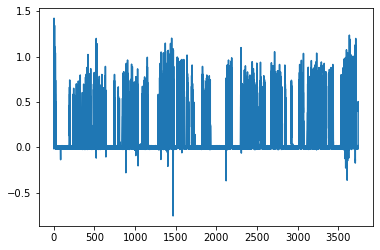

In [9]:
plt.plot(sweepX, sweepY)

Ok, looks our data is formatted as a dictionary, so what are the keys of this dictionary? 

In [69]:
ts_step = 0.0001
sampling_rate_hz = int(1/ts_step)
sampling_rate_hz

10000

In [11]:
#data['Channel_05_ts']

In [12]:
#data['Channel_05_ts_step']

In [13]:
#sampling_rate_hz = int(1/data['Channel_05_ts_step'][0][0])
#data['Channel_05'][:sampling_rate_hz * 60].shape

Text(0, 0.5, 'Voltage')

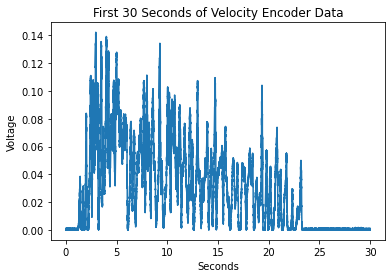

In [9]:
plt.plot(np.arange(sampling_rate_hz* 30)/sampling_rate_hz, np.abs(data['Channel_05'][:sampling_rate_hz * 30]))
plt.title('First 30 Seconds of Velocity Encoder Data')
plt.xlabel('Seconds')
plt.ylabel('Voltage')

In the plot above, we plot Voltage against Seconds, where we see a single movement bout. Let's see what happens if we just start and end a bout whenever Voltage is above .1

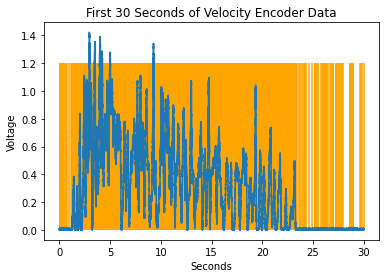

In [76]:

#above_cutoff = data['Channel_05'] > voltage_cutoff
above_cutoff = sweepY > voltage_cutoff
plt.vlines(np.arange(sampling_rate_hz * 30)[above_cutoff[:sampling_rate_hz * 30].reshape(-1)]/sampling_rate_hz, ymin = 0, ymax= 1.2, color = 'orange')
plt.plot(np.arange(sampling_rate_hz* 30)/sampling_rate_hz, np.abs(sweepY[:sampling_rate_hz * 30]))
plt.title('First 30 Seconds of Velocity Encoder Data')
plt.xlabel('Seconds')
plt.ylabel('Voltage')
#plt.savefig('example.png')
plt.show()

That actually works pretty well, but we have to account for those small gaps - how do we do that? We need to implement the minimum length of time our velocity encoder has to fall below the threshold. This is encoded by the `minimum_duration`. To get the number of timesteps that we need to look out for, we need to multiply `minimum_duration` by `sampling_rate_hz`. Then, for every `TRUE` value in `above_cutoff` (this is a boolean array with `TRUE` if it's above the cutoff and `FALSE` if it's below), we check if the next `minimum_duration` * `sampling_rate_hz` time steps are `FALSE`. If they are, we can stop the movement epoch. If they aren't, we continue until the next `TRUE`, where we start checking again. 

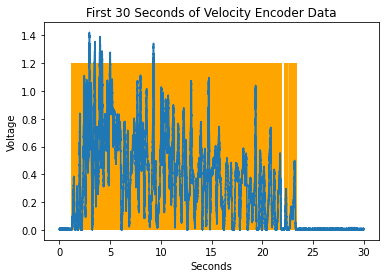

In [80]:
above_cutoff = sweepY > voltage_cutoff
plt.vlines(np.arange(sampling_rate_hz * 30)[above_cutoff[:sampling_rate_hz * 30].reshape(-1)]/sampling_rate_hz, ymin = 0, ymax= 1.2, color = 'orange')
plt.plot(np.arange(sampling_rate_hz* 30)/sampling_rate_hz, np.abs(sweepY[:sampling_rate_hz * 30]))
plt.title('First 30 Seconds of Velocity Encoder Data')
plt.xlabel('Seconds')
plt.ylabel('Voltage')
#plt.savefig('example.png')
plt.show()

In [81]:
True_followed_by_false = above_cutoff[:-1] * (1 - above_cutoff[1:]) # this gives us an array of boolean values whenever there is a True followed by a False
indices = np.where(True_followed_by_false == 1)[0] + 1 # this converts the array of boolean values to a list of indices
for i, idx in enumerate(indices): 
    """
    We want to check if the next minumum_duration of seconds are
    all False
    """
    end_of_array = above_cutoff.shape[0] - 1
    curr_slice = above_cutoff[idx: min(idx + (minumum_duration * sampling_rate_hz), end_of_array)]
    if np.sum(curr_slice) > 10: # if there are more than 10 times it breaks the cutoff 
        if i + 1 != len(indices):
            end = min((minumum_duration * sampling_rate_hz + 1), (indices[i + 1] - idx))
        else: 
            end = min((minumum_duration * sampling_rate_hz + 1), len(above_cutoff) - idx - 1)
        above_cutoff[idx: idx + end] = np.array([True] * end)
        


In [83]:
def plot_trace(start, end, sampling_rate_hz, above_cutoff, sweepY, save_name = ''):
    #%matplotlib widget
    start_idx = sampling_rate_hz  * start
    end_idx = sampling_rate_hz * end
    xaxis = np.arange(sampling_rate_hz * (end - start))
    plt.vlines(start + xaxis[above_cutoff[start_idx:end_idx].reshape(-1)]/sampling_rate_hz, ymin = 0, ymax= 1.2, color = 'orange')
    plt.plot(start + xaxis/sampling_rate_hz, sweepY[start_idx:end_idx], label = 'Signal')
    plt.title('Velocity Encoder Data from {} to {} seconds'.format(start, end))
    plt.xlabel('Seconds')
    #plt.ion()
    plt.ylabel('Voltage')
    plt.legend()
    if save_name != '':
        plt.savefig(save_name)

    plt.show()

The function `plot_trace` takes in two arguments in seconds: start and end - these are currently set to 0 and 30 in the block below. The rest of the arguments won't need to be changed.

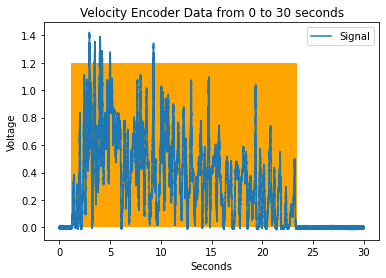

In [84]:
plot_trace(0, 30, sampling_rate_hz, above_cutoff, sweepY, save_name = '')

In [ ]:
above_cutoff[0*sampling_rate_hz:30*sampling_rate_hz].shape

# Some preliminary before metrics

Before we start calulating metrics, let's make life a bit easier for us. We want to convert our boolean arrays to sets of indices. Effectively, currently, we have an array that is `True` for every time point that is in the epoch and `False` otherwise. Instead, we want sets of indices marking the start of every bout and the end of every bout. This would be structured: `[(start, end), (start, end)]`

In [28]:
"""
indices = []
is_first = True
window_range = 10
for idx, frame in enumerate(above_cutoff): 
    if frame and (idx == 0 or not above_cutoff[idx - 1] ):
        start = idx
    if not frame and above_cutoff[idx - 1] and not idx == 0:
        end = idx
        if start>=end:
            continue
        indices.append((start, end))
"""

'\nindices = []\nis_first = True\nwindow_range = 10\nfor idx, frame in enumerate(above_cutoff): \n    if frame and (idx == 0 or not above_cutoff[idx - 1] ):\n        start = idx\n    if not frame and above_cutoff[idx - 1] and not idx == 0:\n        end = idx\n        if start>=end:\n            continue\n        indices.append((start, end))\n'

In [85]:
from itertools import accumulate, groupby
indices = list(accumulate(sum(1 for _ in g) for _,g in groupby(above_cutoff)))


In [86]:
#for i in indices:
#    start, end = i
#    start = start/sampling_rate_hz
#    end = end/sampling_rate_hz
#    plt.vlines([start, end], color = 'orange', ymin = 0, ymax = 1.2)
#start, end = indices[1]
%matplotlib widget
indices_seconds = [i/sampling_rate_hz for i in indices]
plt.vlines(indices_seconds, color = 'orange', ymin = 0, ymax = 1.2)    
plt.plot(sweepX, sweepY)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [29]:
indices

#sweepY[int(sampling_rate_hz * 23.2824):int(sampling_rate_hz * 23.2826)]
len(indices)

872

In [58]:
def duration_of_all_bouts(indices):
    durations = []
    for i in range(len(indices) - 1):
        start, end = indices[i], indices[i + 1]
        start = start/sampling_rate_hz
        end = end/sampling_rate_hz
        durations.append(end - start)
        i += 2
    return durations

In [59]:
def max_velocity_bouts(indices):
    max_vels = []
    for i in range(len(indices) - 1):
        start, end = indices[i], indices[i + 1]
        max_vels.append(max(sweepY[int(start): int(end)]) * 100)
        i += 2
    return max_vels

In [60]:
def avg_velocity_bouts(indices):
    avg_vels = []
    for i in range(len(indices) - 1):
        start, end = indices[i], indices[i + 1]
        avg_vels.append(np.average(sweepY[int(start): int(end)]) * 100)
        i += 2
    return avg_vels

In [89]:
def avg_velocity(sweepY):
    return np.nanmean(sweepY) * 100
def max_velocity(sweepY):
    return max(sweepY) * 100


In [92]:
max_velocity(sweepY)

142.2119140625

In [93]:
avg_velocity(sweepY)

9.525179117918015

In [94]:
max_velocity_bouts(indices)

[142.2119140625,
 1.8310546875,
 2.13623046875,
 1.8310546875,
 2.13623046875,
 1.8310546875,
 2.44140625,
 1.8310546875,
 2.13623046875,
 1.8310546875,
 2.13623046875,
 1.8310546875,
 2.13623046875,
 1.8310546875,
 2.13623046875,
 1.8310546875,
 74.15771484375,
 1.52587890625,
 2.13623046875,
 1.52587890625,
 2.13623046875,
 1.8310546875,
 2.13623046875,
 1.8310546875,
 2.44140625,
 1.8310546875,
 2.13623046875,
 1.8310546875,
 65.00244140625,
 1.8310546875,
 2.44140625,
 1.8310546875,
 2.13623046875,
 1.52587890625,
 2.13623046875,
 1.8310546875,
 2.13623046875,
 1.8310546875,
 2.13623046875,
 1.8310546875,
 2.13623046875,
 1.8310546875,
 2.13623046875,
 1.8310546875,
 40.8935546875,
 1.8310546875,
 2.13623046875,
 1.8310546875,
 2.13623046875,
 1.8310546875,
 69.88525390625,
 1.8310546875,
 2.13623046875,
 1.8310546875,
 2.13623046875,
 1.8310546875,
 2.13623046875,
 1.8310546875,
 56.15234375,
 1.8310546875,
 2.74658203125,
 1.8310546875,
 2.44140625,
 1.8310546875,
 2.13623046875,

In [95]:
avg_velocity_bouts(indices)

[40.70390164852142,
 1.6902042552828789,
 2.13623046875,
 1.7547607421875,
 2.13623046875,
 1.52587890625,
 2.237955667078495,
 1.77001953125,
 2.13623046875,
 1.678466796875,
 2.13623046875,
 1.8310546875,
 2.13623046875,
 1.64794921875,
 2.13623046875,
 -0.1175178331322968,
 18.434028327465057,
 1.52587890625,
 2.13623046875,
 1.52587890625,
 2.13623046875,
 1.8310546875,
 2.13623046875,
 1.61307193338871,
 2.2125244140625,
 1.787458173930645,
 2.13623046875,
 -0.09020445868372917,
 12.024623155593872,
 1.8310546875,
 2.339681051671505,
 1.3020833022892475,
 2.13623046875,
 1.3224284164607525,
 2.13623046875,
 1.52587890625,
 2.13623046875,
 1.430511474609375,
 2.13623046875,
 1.3987223617732525,
 2.13623046875,
 1.4554536901414394,
 2.13623046875,
 -0.0848322466481477,
 9.392926096916199,
 1.428777538239956,
 2.13623046875,
 1.446267869323492,
 2.13623046875,
 -0.08834627806209028,
 15.556709468364716,
 1.344422996044159,
 2.13623046875,
 1.39024518430233,
 2.13623046875,
 1.4426491

In [96]:
duration_of_all_bouts(indices)

[22.0326,
 0.001300000000000523,
 9.999999999976694e-05,
 0.001200000000000756,
 9.999999999976694e-05,
 0.00019999999999953388,
 0.00030000000000285354,
 0.0004999999999988347,
 9.999999999976694e-05,
 0.0007999999999981355,
 0.00010000000000331966,
 0.00019999999999953388,
 9.999999999976694e-05,
 0.0004999999999988347,
 0.00019999999999953388,
 168.2071,
 5.075799999999987,
 0.0002000000000066393,
 0.00010000000000331966,
 0.00010000000000331966,
 0.00010000000000331966,
 0.0003999999999848569,
 0.00030000000000995897,
 0.0006999999999948159,
 0.0004000000000132786,
 0.0006999999999948159,
 0.00010000000000331966,
 37.1704,
 12.395499999999998,
 0.00010000000000331966,
 0.00029999999998153726,
 0.0015000000000213731,
 0.00010000000000331966,
 0.0005999999999914962,
 0.00010000000000331966,
 0.001599999999996271,
 0.00010000000000331966,
 0.001599999999996271,
 0.00010000000000331966,
 0.0011999999999829924,
 0.00010000000000331966,
 0.002600000000001046,
 0.00010000000000331966,
 20

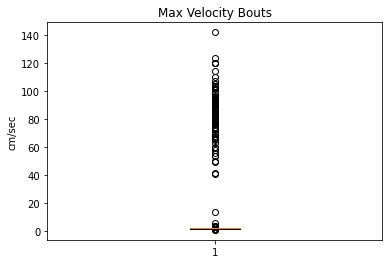

In [91]:
%matplotlib inline
plt.boxplot(max_velocity_bouts(indices))
plt.title('Max Velocity Bouts')
plt.ylabel('cm/sec')
plt.show()

Text(0, 0.5, 'cm/sec')

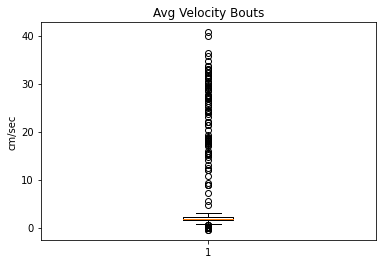

In [65]:
%matplotlib inline
plt.boxplot(avg_velocity_bouts(indices))
plt.title('Avg Velocity Bouts')
plt.ylabel('cm/sec')

#avg_velocity_bouts(indices)

Text(0, 0.5, 'Seconds')

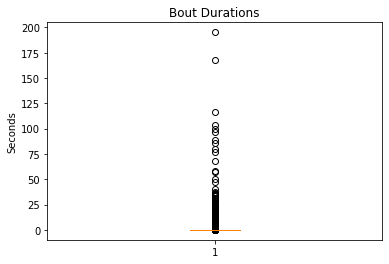

In [66]:
plt.boxplot(duration_of_all_bouts(indices))
plt.title('Bout Durations')
plt.ylabel('Seconds')